# Amazon Textract SDK Example 
_**Use Amazon Textract Python SDK to get table content from pdf**_


---

---

## Contents
1. [Background](#Background)
1. [S3](#S3)
1. [Textract](#Textract)
1. [Run](#Run)
1. [Output](#Output)
1. [Delete](#Delete)

---


## Background
This notebook illustrates how one can use Amazon Textract Python SDK to parse PDF document and extract table information. We will be loading a PDF file a sample 2 page document taken from SEC-10k document to S3. Using Amazon Textract Python SDK we will be processing PDF to get the desired output. From output we will be extracting Revenue. More information required can be found in below links. 

* Analyzing Document Text with Amazon Textract using python SDK
    - https://docs.aws.amazon.com/textract/latest/dg/analyzing-document-text.html
    - https://docs.aws.amazon.com/textract/latest/dg/detecting-document-text.html
* Using AWS SDK for Python (Boto 3), start_document_analysis and get_document_analysis.
    - https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/textract.html
    -https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/textract.html#Textract.Client.start_document_analysis
    -https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/textract.html#Textract.Client.get_document_analysis	
* For details of Detecting or Analyzing Text in a Multipage Document can be found below
    - https://docs.aws.amazon.com/textract/latest/dg/async-analyzing-with-sqs.html
    - Example SDK implementation can be found here https://github.com/aws-samples/amazon-textract-serverless-large-scale-document-processing



---

## S3
### Load file to S3

Lets use [Amazon Web Services'](https://aws.amazon.com/) (AWS) Simple Storage Solution [(S3)](https://aws.amazon.com/s3/?hp=tile&so-exp=below), which provides cloud-based file storage. You can find a fairly in-depth description of what Jupyter notebooks are and how to use them [here](https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook). An important component of making notebooks is writing descriptions in markdown, for which I found [this cheatsheet](https://colab.research.google.com/notebook#fileId=/v2/external/notebooks/markdown_guide.ipynb) to be quite helpful.

### Working with S3 web interface

To start using S3 you can use the web interface to set it up and load a sample file, following [these directions](https://aws.amazon.com/getting-started/tutorials/backup-files-to-amazon-s3/). While working with this interface is nice, what is perhaps more interesting for programmers is the command line interface (CLI) and programmatic access (we will focus on Python).

### Working with S3 via the CLI and Python SDK

Before it is possible to work with S3 programmatically, it is necessary to set up an AWS IAM User. [This guide](https://aws.amazon.com/getting-started/tutorials/backup-to-s3-cli/) shows how to do that, plus other steps necessary to install and configure AWS. To work with with Python SDK, it is also necessary to install boto3 (which we can do with the command `pip install boto3`). Below we will use SDK, along with the equivalent commands in the CLI. First, however, we need to import boto3 and initialize and S3 object.

In [25]:
import boto3, os

s3 = boto3.resource('s3')

Note: You can also do `s3 = boto3.client('s3')`, but some functionality won't be possible (like s3.Bucket()).

We will use existing bucket `sagemaker-test-cdse-expedition-useast1`

### Upload file
Lets use CapitalOne-2019-10-k-39-40.pdf to upload

In [26]:
bucket_name = "sagemaker-test-cdse-expedition-useast1"
#bucket_name = "test-textform-01"

folder_name = "sriharshams2"
s3.meta.client.upload_file('CapitalOne-2019-10-k-39-40.pdf', bucket_name, folder_name+'/CapitalOne-2019-10-k-39-40.pdf')

Note that if s3 was a client instead of a resource, the command becomes s3.upload_file('CapitalOne-2019-10-k-39-40.pdf', bucket_name, folder_name+'/CapitalOne-2019-10-k-39-40.pdf')



### Listing buckets

The following code can be used to see files in above created bucket:

In [27]:
for obj in s3.Bucket(name=bucket_name).objects.all():
    if obj.key == folder_name+'/'+'CapitalOne-2019-10-k-39-40.pdf':
        print(os.path.join(obj.bucket_name, obj.key))


test-textform-01/sriharshams2/CapitalOne-2019-10-k-39-40.pdf


## Textract

All details of textract to read PDF files and extract the required content

Import all required libraries

In [28]:
import sys
import os
from urllib.parse import urlparse
import boto3
import time
from tdp import DocumentProcessor
from og import OutputGenerator
from helper import FileHelper, S3Helper

### Textract SDK details
Following files has various helper functions used for demo of Textract
1. helper.py : Contains utility functions of s3 and file paths and boto3 client init
2. tdp.py : Textract document processor has details of Image & PDF processor, we can see the PdfProcessor implementation in below cell.
3. og.py: Contains output parsing of the response from Textract API to parse text, form and table outputs and saving them in differnt files.


In [29]:
# PdfProcessor uses textract text_detection or document_analysis api implementation
class PdfProcessor:
    def __init__(self, inputParameters):
        self.inputParameters = inputParameters

    def _startJob(self):
        response = None
        client = AwsHelper().getClient('textract', self.inputParameters.awsRegion)
        if(not self.inputParameters.detectForms and not self.inputParameters.detectTables):
            response = client.start_document_text_detection(
            DocumentLocation={
                'S3Object': {
                    'Bucket': self.inputParameters.bucketName,
                    'Name': self.inputParameters.documentPath
                }
            })
        else:
            features  = []
            if(self.inputParameters.detectTables):
                features.append("TABLES")
            if(self.inputParameters.detectForms):
                features.append("FORMS")

            response = client.start_document_analysis(
            DocumentLocation={
                'S3Object': {
                    'Bucket': self.inputParameters.bucketName,
                    'Name': self.inputParameters.documentPath
                }
            },
            FeatureTypes=features
            )

        return response["JobId"]

    def _isJobComplete(self, jobId):
        time.sleep(5)
        client = AwsHelper().getClient('textract', self.inputParameters.awsRegion)
        if(not self.inputParameters.detectForms and not self.inputParameters.detectTables):
            response = client.get_document_text_detection(JobId=jobId)
        else:
            response = client.get_document_analysis(JobId=jobId)
        status = response["JobStatus"]
        print(status)

        while(status == "IN_PROGRESS"):
            time.sleep(5)
            if(not self.inputParameters.detectForms and not self.inputParameters.detectTables):
                response = client.get_document_text_detection(JobId=jobId)
            else:
                response = client.get_document_analysis(JobId=jobId)
            status = response["JobStatus"]
            print(status)

        return status

    def _getJobResults(self, jobId):

        pages = []

        time.sleep(5)

        client = AwsHelper().getClient('textract', self.inputParameters.awsRegion)
        if(not self.inputParameters.detectForms and not self.inputParameters.detectTables):
            response = client.get_document_text_detection(JobId=jobId)
        else:
            response = client.get_document_analysis(JobId=jobId)
        pages.append(response)
        print("Resultset page recieved: {}".format(len(pages)))
        nextToken = None
        if('NextToken' in response):
            nextToken = response['NextToken']
            #print("Next token: {}".format(nextToken))

        while(nextToken):
            time.sleep(5)

            if(not self.inputParameters.detectForms and not self.inputParameters.detectTables):
                response = client.get_document_text_detection(JobId=jobId, NextToken=nextToken)
            else:
                response = client.get_document_analysis(JobId=jobId, NextToken=nextToken)

            pages.append(response)
            print("Resultset page recieved: {}".format(len(pages)))
            nextToken = None
            if('NextToken' in response):
                nextToken = response['NextToken']
                #print("Next token: {}".format(nextToken))

            #if(len(pages) > 20):
            #    break

        return pages

    def run(self):
        jobId = self._startJob()
        print("Started Asyc Job with Id: {}".format(jobId))
        status = self._isJobComplete(jobId)
        if(status == "SUCCEEDED"):
            responsePages = self._getJobResults(jobId)
            return responsePages

Textractor class provides utility functions to validate input and calling PdfProcessor and output generation.

In [30]:

class Textractor:
    def getInputParameters(self, args):
        event = {}
        i = 0
        if(args):
            while(i < len(args)):
                if(args[i] == '--documents'):
                    event['documents'] = args[i+1]
                    i = i + 1
                if(args[i] == '--region'):
                    event['region'] = args[i+1]
                    i = i + 1
                if(args[i] == '--text'):
                    event['text'] = True
                if(args[i] == '--forms'):
                    event['forms'] = True
                if(args[i] == '--tables'):
                    event['tables'] = True
                """
                if(args[i] == '--insights'):
                    event['insights'] = True
                if(args[i] == '--medical-insights'):
                    event['medical-insights'] = True
                if(args[i] == '--translate'):
                    event['translate'] = args[i+1]
                    i = i + 1"""    

                i = i + 1
        return event

    def validateInput(self, args):

        event = self.getInputParameters(args)

        ips = {}

        if(not 'documents' in event):
            raise Exception("Document or path to a foler or S3 bucket containing documents is required.")

        inputDocument = event['documents']
        idl = inputDocument.lower()

        bucketName = None
        documents = []
        awsRegion = 'us-east-1'

        if(idl.startswith("s3://")):
            o = urlparse(inputDocument)
            bucketName = o.netloc
            path = o.path[1:]
            ar = S3Helper.getS3BucketRegion(bucketName)
            if(ar):
                awsRegion = ar

            if(idl.endswith("/")):
                allowedFileTypes = ["jpg", "jpeg", "png", "pdf"]
                documents = S3Helper.getFileNames(awsRegion, bucketName, path, 1, allowedFileTypes)
            else:
                documents.append(path)
        else:
            if(idl.endswith("/")):
                allowedFileTypes = ["jpg", "jpeg", "png"]
                documents = FileHelper.getFileNames(inputDocument, allowedFileTypes)
            else:
                documents.append(inputDocument)

            if('region' in event):
                awsRegion = event['region']

        ips["bucketName"] = bucketName
        ips["documents"] = documents
        ips["awsRegion"] = awsRegion
        ips["text"] = ('text' in event)
        ips["forms"] = ('forms' in event)
        ips["tables"] = ('tables' in event)
        ips["insights"] = ('insights' in event)
        ips["medical-insights"] = ('medical-insights' in event)
        if("translate" in event):
            ips["translate"] = event["translate"]
        else:
            ips["translate"] = ""

        return ips

    def processDocument(self, ips, i, document):
        print("\nTextracting Document # {}: {}".format(i, document))
        print('=' * (len(document)+30))

        # Get document textracted
        dp = DocumentProcessor(ips["bucketName"], document, ips["awsRegion"], ips["text"], ips["forms"], ips["tables"])
        response = dp.run()
        print("Recieved Textract response...")

        #FileHelper.writeToFile("temp-response.json", json.dumps(response))

        #Generate output files
        print("Generating output...")
        name, ext = FileHelper.getFileNameAndExtension(document)
        opg = OutputGenerator(response,
                    "{}-{}".format(name, ext),
                    ips["forms"], ips["tables"])
        opg.run()

        if(ips["insights"] or ips["medical-insights"] or ips["translate"]):
            opg.generateInsights(ips["insights"], ips["medical-insights"], ips["translate"], ips["awsRegion"])

        print("{} textracted successfully.".format(document))

    def printFormatException(self, e):
        print("Invalid input: {}".format(e))
        print("Valid format:")
        print('- python3 textractor.py --documents mydoc.jpg --text --forms --tables --region us-east-1')
        print('- python3 textractor.py --documents ./myfolder/ --text --forms --tables')
        print('- python3 textractor.py --document s3://mybucket/mydoc.pdf --text --forms --tables')
        print('- python3 textractor.py --document s3://mybucket/ --text --forms --tables')

    def run(self, args):

        ips = None
        try:
            ips = self.validateInput(args)
        except Exception as e:
            self.printFormatException(e)

        #try:
        i = 1
        totalDocuments = len(ips["documents"])

        print("\n")
        print('*' * 60)
        print("Total input documents: {}".format(totalDocuments))
        print('*' * 60)

        for document in ips["documents"]:
            self.processDocument(ips, i, document)

            remaining = len(ips["documents"])-i

            if(remaining > 0):
                print("\nRemaining documents: {}".format(remaining))

                print("\nTaking a short break...")
                time.sleep(20)
                print("Allright, ready to go...\n")

            i = i + 1

        print("\n")
        print('*' * 60)
        print("Successfully textracted documents: {}".format(totalDocuments))
        print('*' * 60)
        print("\n")
        #except Exception as e:
        #    print("Something went wrong:\n====================================================\n{}".format(e))

### Run
Create and run Textractor to see the Textractor in action.

In [ ]:
textract_args =[]
textract_args.append("--documents")
textract_args.append("s3://"+bucket_name+"/"+folder_name+"/CapitalOne-2019-10-k-39-40.pdf")
textract_args.append("--text")
textract_args.append("--tables")
textract_args.append("--region")
textract_args.append("us-east-1")

Textractor().run(textract_args)



************************************************************
Total input documents: 1
************************************************************

Textracting Document # 1: sriharshams2/CapitalOne-2019-10-k-39-40.pdf
Calling Textract...
Started Asyc Job with Id: 01cf285a3cc7bf9f8c5a659e563c994627ccecc2ee15d10dc35bac221a2af8cc
IN_PROGRESS
IN_PROGRESS
IN_PROGRESS
IN_PROGRESS
IN_PROGRESS
IN_PROGRESS
IN_PROGRESS
IN_PROGRESS


We successfully extracted data from page1 of CapitalOne-2019-10-k-39-40.pdf

### Output
#### Input pdf image
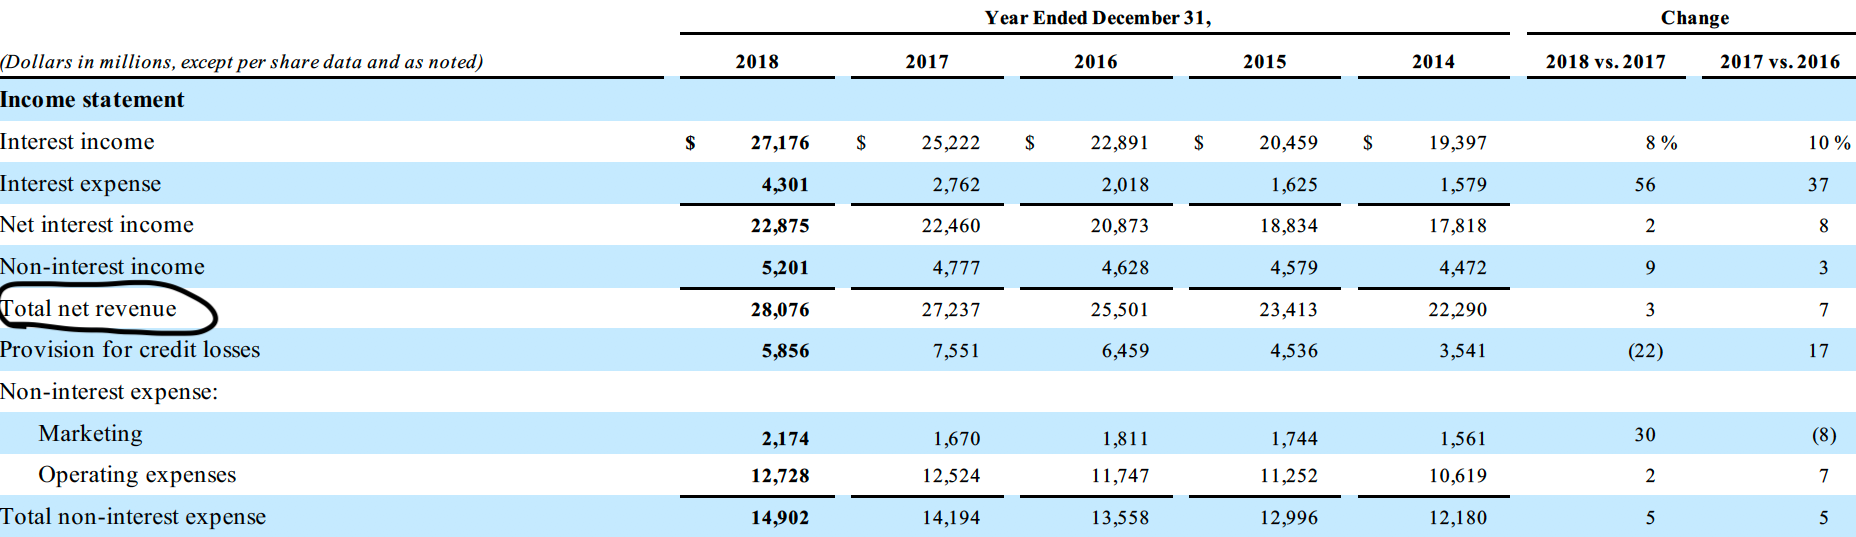

#### Output files
We can see outputs of page1 & page2 in various files.

table from page1 will be extracted in CapitalOne-2019-10-k-39-40-pdf-page-1-tables.csv, our files of interest

In [19]:
! ls CapitalOne-2019-10-k-39-40-pdf*

CapitalOne-2019-10-k-39-40-pdf-page-1-response.json
CapitalOne-2019-10-k-39-40-pdf-page-1-tables.csv
CapitalOne-2019-10-k-39-40-pdf-page-1-text-inreadingorder.txt
CapitalOne-2019-10-k-39-40-pdf-page-1-text.txt
CapitalOne-2019-10-k-39-40-pdf-page-1-words.csv
CapitalOne-2019-10-k-39-40-pdf-page-2-response.json
CapitalOne-2019-10-k-39-40-pdf-page-2-tables.csv
CapitalOne-2019-10-k-39-40-pdf-page-2-text-inreadingorder.txt
CapitalOne-2019-10-k-39-40-pdf-page-2-text.txt
CapitalOne-2019-10-k-39-40-pdf-page-2-words.csv
CapitalOne-2019-10-k-39-40-pdf-response.json


In [20]:
#! pip install pandas

In [21]:
import pandas as pd
page1_table = pd.read_csv("CapitalOne-2019-10-k-39-40-pdf-page-1-tables.csv")
page1_table.head(13)

,,,,,,,Table
NaN,NaN,Year,Ended December,"31,",NaN,Change,NaN
(Dollars in millions except per share data ane as noted),2018,2017,2016,2015,2014,2018 VS. 2017,2017 2016
Income statement,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Interest income,"s 27,176","s 25,222","S 22,891",S 20.459,S 19.397,8%,10%
Interest expense,4.301,"2,762","2,018",1.625,1.579,56,37
Net interest income,"22,875","22,460",20.873,18.834,17.818,2,S
Non-interest income,5.201,"4,777",4.628,4.579,4.472,9,3
Total net revenue,"28,076","27,237","25,501",23.413,22.290,3,7
Provision for credit losses,5.856,7551,6.459,4.536,3.541,(22),17
Non-interest expense:,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
print("Total net revenuce 2018:", str(page1_table[7:8]).split()[4])

Total net revenuce 2018: 28,076


## Delete
### Deleting output 
Delete all the output files generated to rerun the notebook.

In [23]:
! rm -f CapitalOne-2019-10-k-39-40-pdf*

### Deleting folder and uploaded file

The bucket needs to be manually emptied before it can be deleted.

In [24]:
bucket = s3.Bucket(bucket_name)

# empty the bucket
for key in bucket.objects.all():
    if obj.key == folder_name+'/'+'CapitalOne-2019-10-k-39-40.pdf':
        key.delete()
    